In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [3]:
dataset = pd.read_csv("IMDB Dataset.csv")
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [36]:
dataset.loc[128,].review

"This movie was one of the best movies that I have seen this year. I didn't see any cameos in the movie, but it is still pretty good. It is similar to Anchorman in the humor department, but I think this is a better put together movie. It actually has a point. If you are going to see a whole bunch of T&A you will be disappointed. Just a well put together movie!!!! If you have nothing to do for the day or you need a lot of humor, you will find this to be a really good movie. I definitely think that Ebert and Roeper's review of this movie is right on. I mean, I don't really like Ebert on most movies, but this is the movie that I will agree about. The movie contains a good enough story that it is actually believable that these type of people are out there. There is definitely something to be said about how they treat virginity in this movie. Yea, sure, you get laughed at when it is found out about, but it still suggests that you wait. Steve did a wonderful job of portraying the person that

In [4]:
# Initial Data Processing
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# Checking duplicate
dataset.drop_duplicates(keep="first", inplace=True)

In [6]:
dataset.shape

(49582, 2)

In [7]:
dataset.sentiment.value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [8]:
labels = {"negative" : 0, "positive" : 1}

# Feature and Target
X = dataset.review
Y = dataset.sentiment

target = Y.replace(labels).to_numpy()

/tmp/ipykernel_191771/283642269.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = Y.replace(labels).to_numpy()


In [9]:
target

array([1, 1, 1, ..., 0, 0, 0], shape=(49582,))

## Text Processing

In [10]:
def text_processor(text):
    text = text.lower()

    # Removing urls 
    text = re.sub(r'(https?://\S+|www\.\S+)', "", text)
    # Removing HTML Tags
    text = re.sub(r"<.*?>", "", text)
    # Puncuation and special Char
    text = re.sub(r"[^\w\d\s]", " ", text)
    # Remove spaces
    text = text.strip()

    # Stopwords
    text = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
    text = " ".join(text)
    
    # Lemmatization
    text = lemmatizer.lemmatize(text)

    # Removing single letter from sentence
    text = re.sub(r"\s\w{1}\s", "", text)

    return text
    

In [11]:
cleaned_feature = X.apply(text_processor).to_numpy()

In [12]:
cleaned_feature[0]

'reviewers mentioned watching justoz episode ll hooked right exactly happened thing struck oz brutality unflinching scenes violence set right word trust faint hearted timid pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements far away say main appeal fact goes shows wouldndare forget pretty pictures painted mainstream audiences forget charm forget romance oz doesnmess episode saw struck nasty surreal couldnsay ready watched developed taste oz got accustomed high levels graphic violence just violence injustice crooked guards ll sold nickel inmates ll kill order away mannered middle class inmates turned prison bitches lack street skills prison experience watching oz comfortable u

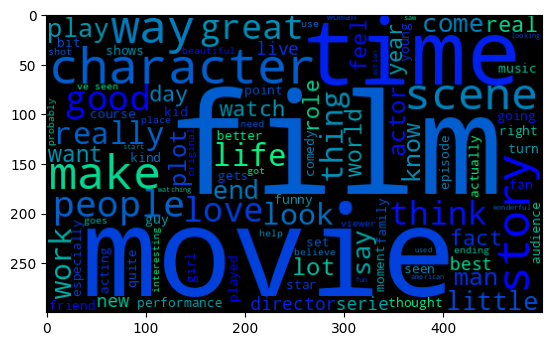

In [13]:
# Visualization

#!pip install wordcloud

from wordcloud import WordCloud

cloud = WordCloud(
    colormap="winter", max_words=100, width=500, height=300
)

pos_reviews = cleaned_feature[target == 1]
image = cloud.generate(" ".join(pos_reviews))

plt.imshow(image)

## Vectorize or Embeddings

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

In [15]:
# Tfidf Vectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(cleaned_feature)

In [16]:
X_tfidf[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]], shape=(1, 253999))

In [17]:
# Word2Vec
tokens = [docs.split() for docs in cleaned_feature]

w2v_model = Word2Vec(
    sentences= tokens,
    vector_size= 200,
    window=4,
    min_count=2
)

In [18]:
# Word2Vec from Gensim

from gensim import downloader

google_word2vec_model = downloader.load("word2vec-google-news-300")

KeyboardInterrupt: 

In [22]:
def vectorize( tokens, model):
    vectors = [
        model[word] for word in tokens if word in model
    ]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    return np.mean(vectors, axis =0)

embeddings = np.array([
    vectorize(token, w2v_model.wv) for token in tokens
])

In [23]:
embeddings.shape

(49582, 200)

## Classification 

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, target, test_size=0.2, stratify=target, shuffle=True, random_state = 99
)

# model
log_reg = LogisticRegression(max_iter=500, random_state=99)
log_reg.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",99
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [26]:
# model #2
svc = SVC(random_state=99)
svc.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [27]:
def evaluate(X_test, y_test, model):
    y_pred= model.predict(X_test)

    cm = confusion_matrix(y_pred, y_test)

    f1 = f1_score(y_pred, y_test)

    acc = accuracy_score(y_pred, y_test)

    print(f"Confision matrix \n {cm}")
    print(f"Accuracy Score : {acc}")
    print(f"F1 Score: {f1}")


In [28]:
evaluate(
    X_test, y_test, model = log_reg
)

Confision matrix 
 [[4204  614]
 [ 736 4363]]
Accuracy Score : 0.8638701220127054
F1 Score: 0.8660182612147678


In [29]:
evaluate(
    X_test, y_test, model = svc
)

Confision matrix 
 [[4214  602]
 [ 726 4375]]
Accuracy Score : 0.866088534839165
F1 Score: 0.8682278229807502


# Saving The model

In [30]:
import pickle

In [31]:
to_save = {
    "embeddings" : w2v_model,
    "classifier" : svc
}

with open("sentiment_classifier.pkl", "wb") as f:
    pickle.dump(to_save, f)

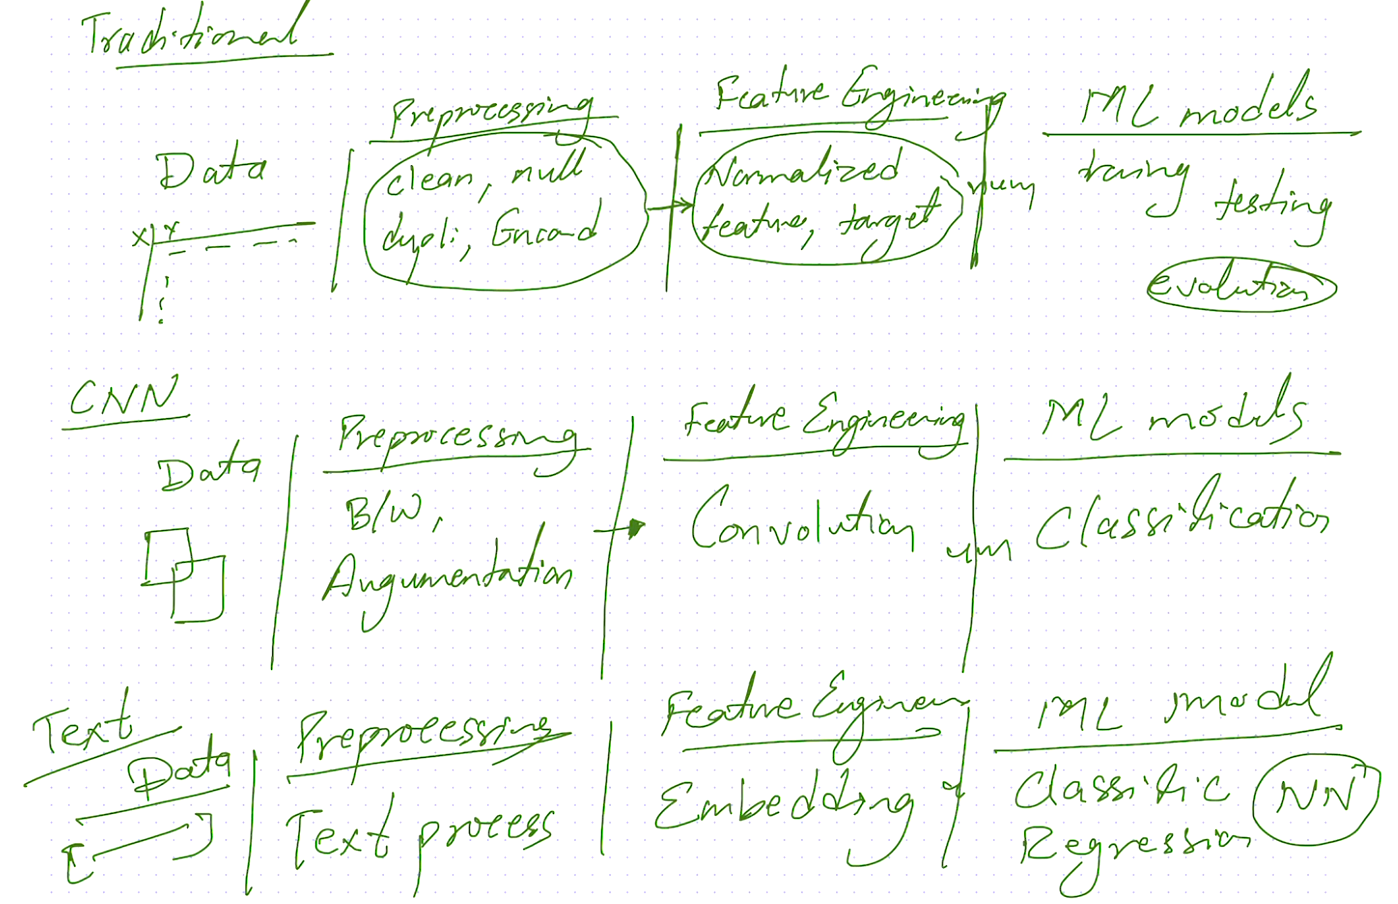